In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.covariance import LedoitWolf

# Data fetching
# Custom data fetcher to replace broken YahooDataProvider
# The qiskit-finance YahooDataProvider has compatibility issues with latest yfinance
import yfinance as yf

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Extract data

In [2]:
# Portfolio parameters
# Data parameters
START_DATE = datetime.now() - timedelta(days=365*2)  # 2 years of data
END_DATE = datetime.now()

# S&P 500 stocks (diversified sector selection)
TICKERS = [
    # Technology
    'NVDA',  # NVIDIA
    'MSFT',  # Microsoft
    'AAPL',  # Apple
    'AMZN',  # Amazon
    'META',  # Meta
    'AVGO',  # Broadcom
    'GOOGL', # Alphabet
    'TSLA',  # Tesla
    'BRK-B', # Berkshire Hathaway
    'WMT',   # Walmart
    # Healthcare
    'JNJ',   # Johnson & Johnson
    'PFE',   # Pfizer
    'MRK',   # Merck & Co.
    'ABBV',  # AbbVie
    'TMO',   # Thermo Fisher Scientific
    # Financials
    'JPM',   # JPMorgan Chase
    'BAC',   # Bank of America
    'WFC',   # Wells Fargo
    'C',     # Citigroup
    'GS',    # Goldman Sachs
    'MS',    # Morgan Stanley
]


print(f"Configuration:")
print(f"  Tickers: {TICKERS}")
print(f"  Date range: {START_DATE.date()} to {END_DATE.date()}")

Configuration:
  Tickers: ['NVDA', 'MSFT', 'AAPL', 'AMZN', 'META', 'AVGO', 'GOOGL', 'TSLA', 'BRK-B', 'WMT', 'JNJ', 'PFE', 'MRK', 'ABBV', 'TMO', 'JPM', 'BAC', 'WFC', 'C', 'GS', 'MS']
  Date range: 2023-11-08 to 2025-11-07


In [5]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch stock data and compute returns, covariance, and correlation.

    Args:
        tickers: List of ticker symbols
        start_date: Start date
        end_date: End date

    Returns:
        mean_returns, covariance_matrix, daily_returns, prices
    """
    print(f"Fetching data for {len(tickers)} stocks from Yahoo Finance...")

    # Download data
    data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)

    # Extract adjusted close prices
    if len(tickers) == 1:
        prices = data['Adj Close'].to_frame()
        prices.columns = tickers
    else:
        prices = data['Adj Close']

    # Drop any NaN values
    prices = prices.dropna()

    print(f"Downloaded {len(prices)} days of price data")

    # Calculate daily returns
    returns = prices.pct_change().dropna()

    # Calculate mean returns (daily)
    mean_returns = returns.mean().values

    # Calculate sample covariance matrix (daily)
    sample_covariance_matrix = returns.cov().values

    return mean_returns, sample_covariance_matrix, returns, prices

mean_returns, covariance_matrix, daily_returns, price_data = fetch_stock_data(
    TICKERS, START_DATE, END_DATE
)

print(f"\nData fetched successfully!")
print(f"Mean returns shape: {mean_returns.shape}")
print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Daily returns shape: {daily_returns.shape}")

Fetching data for 21 stocks from Yahoo Finance...
Downloaded 500 days of price data

Data fetched successfully!
Mean returns shape: (21,)
Covariance matrix shape: (21, 21)
Daily returns shape: (499, 21)


In [6]:
for i, ticker in enumerate(TICKERS):
    print(f"  {ticker}: {mean_returns[i]*252:.2%}")  # Annualized (252 trading days)

  NVDA: 24.02%
  MSFT: 28.48%
  AAPL: 31.97%
  AMZN: 83.55%
  META: 38.54%
  AVGO: 19.24%
  GOOGL: 51.95%
  TSLA: 43.65%
  BRK-B: 51.22%
  WMT: 15.69%
  JNJ: 44.06%
  PFE: 40.46%
  MRK: -3.56%
  ABBV: 46.04%
  TMO: 19.05%
  JPM: 83.50%
  BAC: -1.35%
  WFC: 15.05%
  C: 55.00%
  GS: 43.87%
  MS: 34.80%


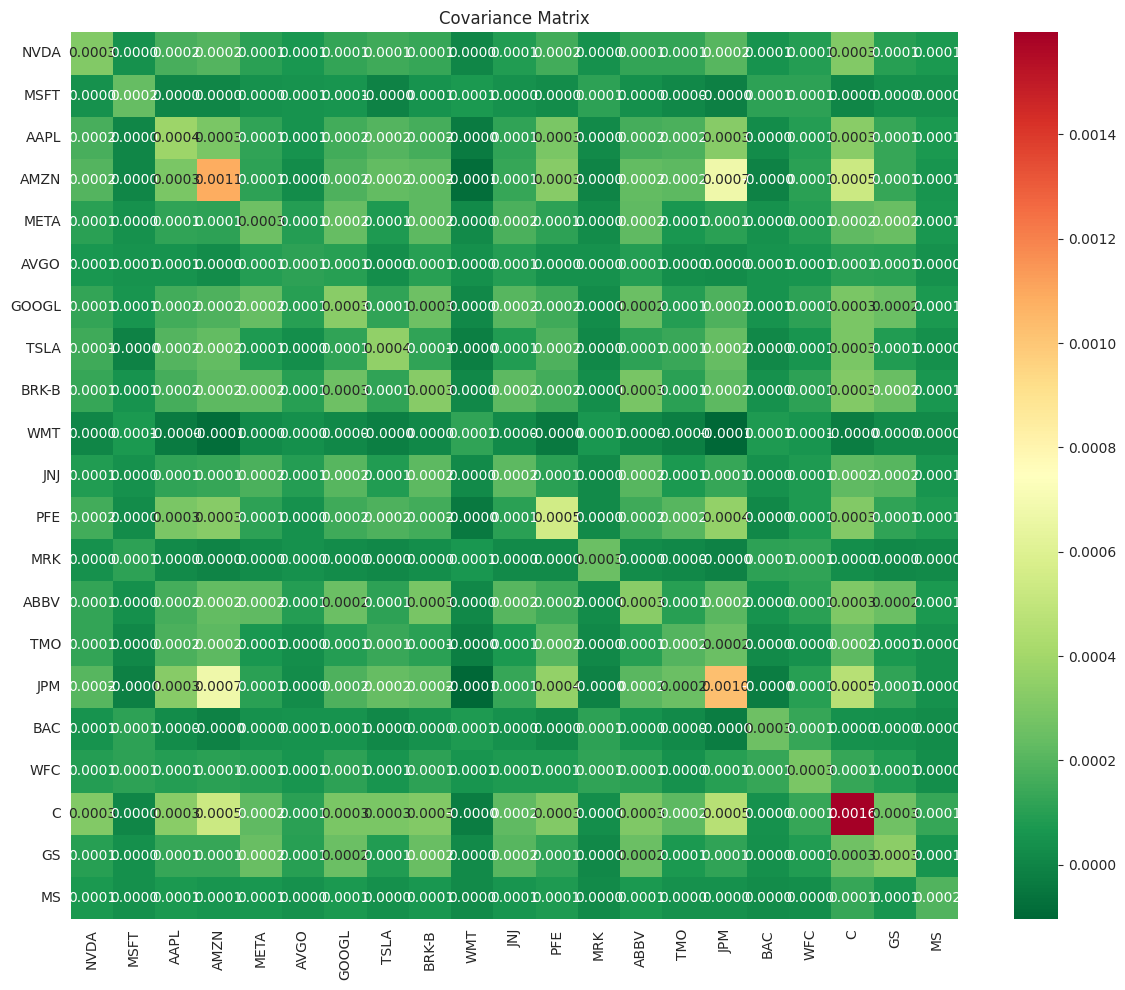

In [7]:
# Visualize covariance matrix - single plot version
plt.figure(figsize=(12, 10))

# Covariance matrix
sns.heatmap(covariance_matrix, annot=True, fmt='.4f', cmap='RdYlGn_r',
            xticklabels=TICKERS, yticklabels=TICKERS)
plt.title('Covariance Matrix')

plt.tight_layout()
plt.show()

# Ledoit-Wolf Function

In [8]:
# Ledoit-Wolf Shrinkage
lw_estimator = LedoitWolf()
lw_estimator.fit(daily_returns)

shrunk_cov_matrix = lw_estimator.covariance_

print("Ledoit-Wolf Estimator")
print(f"Optimal shrinkage coefficient (delta*): {lw_estimator.shrinkage_:.6f}")
print(f"Shrunk covariance matrix shape: {shrunk_cov_matrix.shape}")

Ledoit-Wolf Estimator
Optimal shrinkage coefficient (delta*): 0.050894
Shrunk covariance matrix shape: (21, 21)


# QUBO formulation

In [9]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator

# ---------- Problem Parameters ----------
B = 4                  # cardinality (number of selected assets)
LAMBDA = 5.0           # risk aversion
P_LAYERS = 2           # QAOA depth
SHOTS = 8000           # sampling shots
SEED = 7               # reproducibility
USE_EQUAL_WEIGHT = True

rng = np.random.default_rng(SEED)

# Data from PART 1
mu = mean_returns.copy()            # vector (n,)
Sigma = shrunk_cov_matrix.copy()    # matrix (n,n)
n = len(TICKERS)
assert 1 <= B <= n

# ---------- Classical QUBO ----------
# f(x) = x^T Q x + q^T x with |x|=B; equal weights: w = x/B
if USE_EQUAL_WEIGHT:
    Q = (LAMBDA / (B**2)) * Sigma
    q = -(1.0 / B) * mu
else:
    Q = LAMBDA * Sigma
    q = -mu
Q = 0.5 * (Q + Q.T)  # ensure symmetry

In [10]:
np.savez(
    "portfolio_qubo_data.npz",
    Q=Q,
    q=q,
    mu=mu,
    Sigma=Sigma,
    B=np.array(B),
    TICKERS=np.array(TICKERS)
)

print(f"Successfully saved data")

Successfully saved data
